In [ ]:
!pip install gymnasium
!pip install imageio
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.8 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import imageio.v2 as imageio
from IPython.display import Image, display


In [ ]:
def create_bins(state_space, bins_per_feature=20):
  bins = [np.linspace(low, high, bins_per_feature) for low, high in zip(state_space.low, state_space.high)]
  return bins


def discretize_state(state, bins):
  state_index = tuple(np.digitize(s, b) - 1 for s, b in zip(state, bins))
  return state_index


def choose_action(Q, state, epsilon, n_actions):
  if np.random.random() < epsilon:
    return np.random.randint(n_actions)
  else:
    return np.argmax(Q[state])


def update_q(Q, state, action, reward, next_state, alpha, gamma):
  Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])

In [ ]:
def q_learning(env_name, episodes=5000, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.05, bins_per_feature=20, render_interval=500):
  env = gym.make(env_name)
  bins = create_bins(env.observation_space, bins_per_feature)
  n_actions = env.action_space.n


  Q = np.zeros(tuple([bins_per_feature]*len(env.observation_space.low) + [n_actions]))
  rewards = []


  for episode in range(episodes):
    state = discretize_state(env.reset()[0], bins)
    done = False
    total_reward = 0


    while not done:
      action = choose_action(Q, state, epsilon, n_actions)
      next_state_cont, reward, done, truncated, _ = env.step(action)
      next_state = discretize_state(next_state_cont, bins)


      update_q(Q, state, action, reward, next_state, alpha, gamma)
      state = next_state
      total_reward += reward


      rewards.append(total_reward)
      epsilon = max(epsilon_min, epsilon * epsilon_decay)


      if episode % render_interval == 0:
        clear_output(wait=True)
        print(f"Episode: {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")


  env.close()
  return Q, rewards

In [ ]:
Q_mountain, rewards_mountain = q_learning('MountainCar-v0', episodes=2000)

Episode: 1500, Reward: -141.0, Epsilon: 0.050


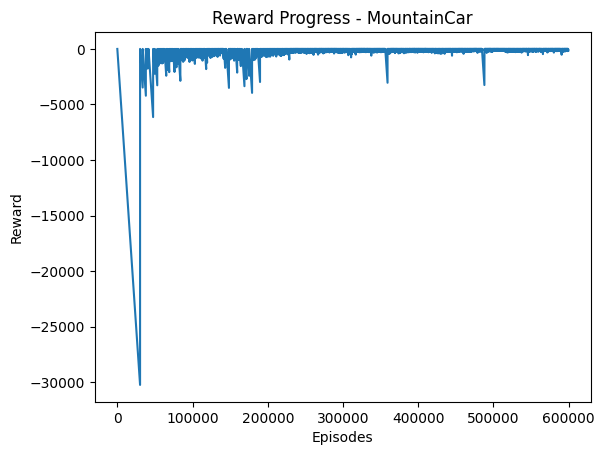

In [ ]:
plt.plot(rewards_mountain)
plt.title('Reward Progress - MountainCar')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

In [ ]:
def test_mountain_car(Q, env_name='MountainCar-v0', tests=5, bins_per_feature=20, render_mode=None):
    env = gym.make(env_name, render_mode=render_mode)
    bins = create_bins(env.observation_space, bins_per_feature)
    n_actions = env.action_space.n
    goal_reached_count = 0
    all_test_frames = []


    print(f"\nRunning {tests} tests for the agent...")


    for test in range(tests):
        state = discretize_state(env.reset()[0], bins)
        done = False
        total_reward = 0
        goal_reached_in_test = False
        frames = []

        while not done:
            if render_mode is not None:
                frame = env.render()
                if frame is not None:
                    frames.append(frame)


            action = np.argmax(Q[state])
            next_state_cont, reward, done, truncated, _ = env.step(action)
            next_state = discretize_state(next_state_cont, bins)


            state = next_state
            total_reward += reward


            if next_state_cont[0] >= 0.5:
                goal_reached_in_test = True
                break


        if goal_reached_in_test:
            goal_reached_count += 1
            print(f"Test {test + 1}: Goal reached!")
            if render_mode is not None:
                all_test_frames.append(frames)
        else:
            print(f"Test {test + 1}: Goal not reached.")


    env.close()
    print(f"\nGoal reached in {goal_reached_count}/{tests} tests.")


    return all_test_frames, goal_reached_count

test_frames, goal_count = test_mountain_car(Q_mountain, render_mode='rgb_array')


Running 5 tests for the agent...
Test 1: Goal reached!
Test 2: Goal reached!
Test 3: Goal reached!
Test 4: Goal reached!
Test 5: Goal reached!

Goal reached in 5/5 tests.


In [ ]:
def render_frame(t_frames):
  for i, frames in enumerate(t_frames):
      filename = f'mountain_car_test_{i+1}.gif'
      imageio.mimsave(filename, frames, duration=50)
      print(f"Generated GIF: {filename}")

In [ ]:
def display_gifs(t_frames):
  for i in range(len(t_frames)):
    filename = f'mountain_car_test_{i+1}.gif'
    img = Image(filename=filename)
    display(img)

Generated GIF: mountain_car_test_1.gif
Generated GIF: mountain_car_test_2.gif
Generated GIF: mountain_car_test_3.gif
Generated GIF: mountain_car_test_4.gif
Generated GIF: mountain_car_test_5.gif


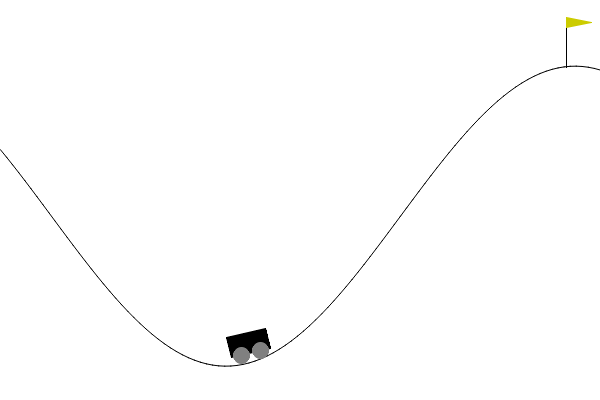

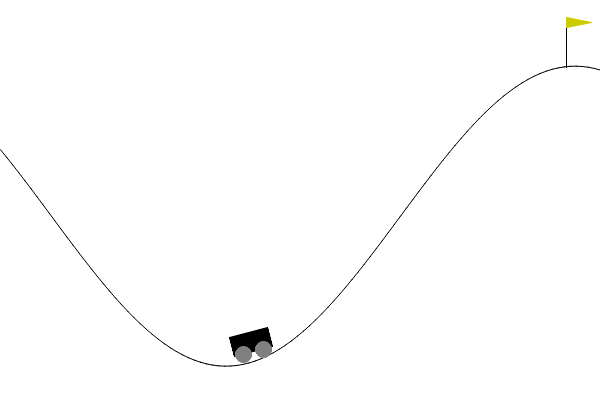

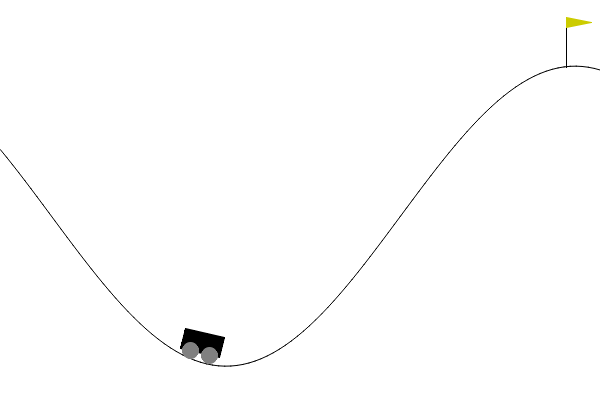

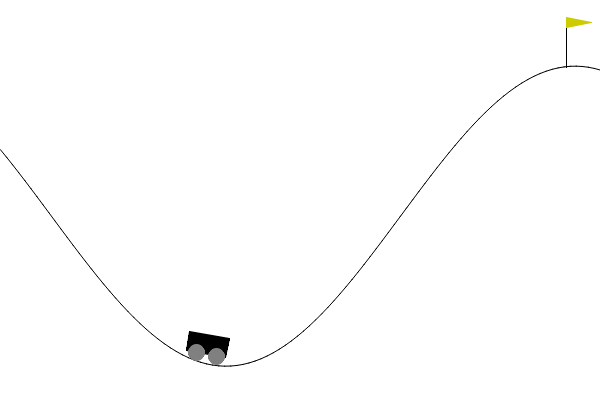

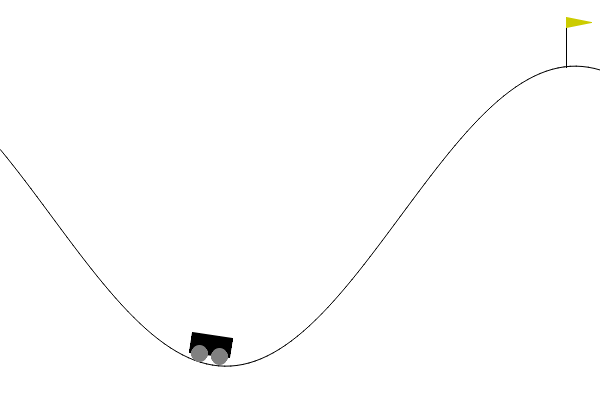

In [ ]:
render_frame(test_frames)
display_gifs(test_frames)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

class RouletteEnv:
    def __init__(self, start_balance=50, target_balance=100, max_steps=300):
        self.start_balance = start_balance
        self.target_balance = target_balance
        self.max_steps = max_steps
        self.bet_sizes = [1, 5, 10]
        self.numbers = 37
        self.action_space = self.numbers * len(self.bet_sizes)
        self.reset()

    def reset(self):
        self.balance = self.start_balance
        self.steps = 0
        return self._discretize_balance(self.balance)

    def _discretize_balance(self, balance):
        return min(balance // 2, 150)

    def step(self, action):
        number_choice = action % self.numbers
        bet_size = self.bet_sizes[action // self.numbers]

        reward = 0
        for _ in range(5):  # average spins
            spin = np.random.randint(0, 37)
            if spin == number_choice:
                reward += 35 * bet_size
            else:
                reward -= bet_size

        self.balance += reward
        self.steps += 1

        done = self.balance <= 0 or self.balance >= self.target_balance or self.steps >= self.max_steps

        shaped_reward = reward
        if self.balance >= self.target_balance:
            shaped_reward += 100
        elif self.balance <= 0:
            shaped_reward -= 50

        next_state = self._discretize_balance(self.balance)
        return next_state, shaped_reward, done

In [ ]:
def q_learning(
    episodes=8000,
    alpha=0.15,
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.05,
    epsilon_decay=0.9994
):
    env = RouletteEnv()
    state_space = 151
    action_space = env.action_space
    Q = np.zeros((state_space, action_space))
    rewards_per_episode = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(env.max_steps):
            if random.random() < epsilon:
                action = random.randint(0, action_space - 1)
            else:
                action = np.argmax(Q[state])

            next_state, reward, done = env.step(action)
            total_reward += reward

            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            state = next_state

            if done:
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

        if (ep + 1) % 1000 == 0:
            avg_reward = np.mean(rewards_per_episode[-1000:])
            print(f"Episode {ep+1}/{episodes} | Avg Reward: {avg_reward:.2f}")

    return Q, rewards_per_episode, env

In [ ]:
Q, rewards, env = q_learning()

Episode 1000/8000 | Avg Reward: -24.76
Episode 2000/8000 | Avg Reward: -22.65
Episode 3000/8000 | Avg Reward: -16.08
Episode 4000/8000 | Avg Reward: -4.84
Episode 5000/8000 | Avg Reward: -0.55
Episode 6000/8000 | Avg Reward: -1.08
Episode 7000/8000 | Avg Reward: -2.77
Episode 8000/8000 | Avg Reward: 2.36


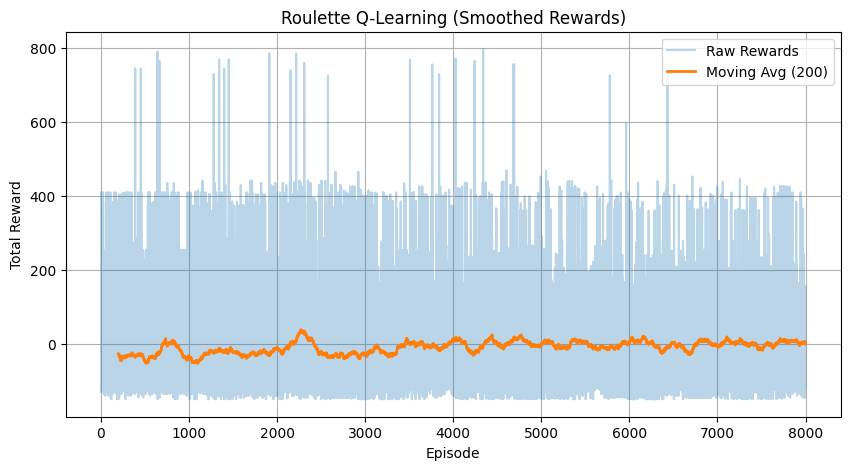

In [ ]:
def plot_with_moving_average(rewards, window=200):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, alpha=0.3, label="Raw Rewards")

    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window - 1, len(rewards)), moving_avg, label=f"Moving Avg ({window})", linewidth=2)

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Roulette Q-Learning (Smoothed Rewards)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_with_moving_average(rewards)

In [ ]:
def test_agent(Q, env, runs=10):
    success_count = 0
    for r in range(runs):
        state = env.reset()
        total_reward = 0
        for _ in range(env.max_steps):
            action = np.argmax(Q[state])
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            if done:
                if env.balance >= env.target_balance:
                    success_count += 1
                break
        print(f"Test {r+1}: Final Balance = {env.balance}, Total Reward = {total_reward}")

    print(f"\nGoal Reached in {success_count}/{runs} tests "
          f"({(success_count / runs) * 100:.1f}% success rate)")




In [ ]:
test_agent(Q, env)

Test 1: Final Balance = -19, Total Reward = -119
Test 2: Final Balance = 102, Total Reward = 152
Test 3: Final Balance = 0, Total Reward = -100
Test 4: Final Balance = 0, Total Reward = -100
Test 5: Final Balance = 162, Total Reward = 212
Test 6: Final Balance = 100, Total Reward = 150
Test 7: Final Balance = -18, Total Reward = -118
Test 8: Final Balance = 0, Total Reward = -100
Test 9: Final Balance = 0, Total Reward = -100
Test 10: Final Balance = 104, Total Reward = 154

Goal Reached in 4/10 tests (40.0% success rate)


In [ ]:
# Q2: Apply Deep Reinforcement Learning (DQN) for MountainCar-v0
import gym
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt

# Create environment
env = gym.make('MountainCar-v0')

# DQN parameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
batch_size = 64
episodes = 400

# Replay memory
memory = deque(maxlen=20000)

# Build Neural Network model
def build_model():
    model = Sequential([
        Input(shape=(state_size,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

model = build_model()

# Choose an action using epsilon-greedy strategy
def act(state):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

# Replay experience and train the network
def replay():
    global epsilon
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    states, targets = [], []
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target = reward + gamma * np.amax(model.predict(next_state, verbose=0)[0])
        target_f = model.predict(state, verbose=0)
        target_f[0][action] = target
        states.append(state[0])
        targets.append(target_f[0])
    model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Training loop
rewards_list = []
for e in range(episodes):
    state = env.reset()
    # Some gym versions return (obs, info), handle both
    if isinstance(state, tuple):
        state = state[0]
    state = np.array(state).reshape(1, -1)
    total_reward = 0
    done = False

    while not done:
        action = act(state)
        step_result = env.step(action)

        # Handle both 4- and 5-value outputs (Gym vs Gymnasium)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = step_result

        next_state = np.array(next_state).reshape(1, -1)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        replay()

        if done:
            print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")
            break

    rewards_list.append(total_reward)

env.close()

# Plot learning performance
plt.plot(rewards_list)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Learning Curve for MountainCar-v0')
plt.show()
